<a href="https://www.kaggle.com/code/dataranch/iran-protests-tweets-xgboost-fastai-eda?scriptVersionId=107608825" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Iran Protests Tweets | Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

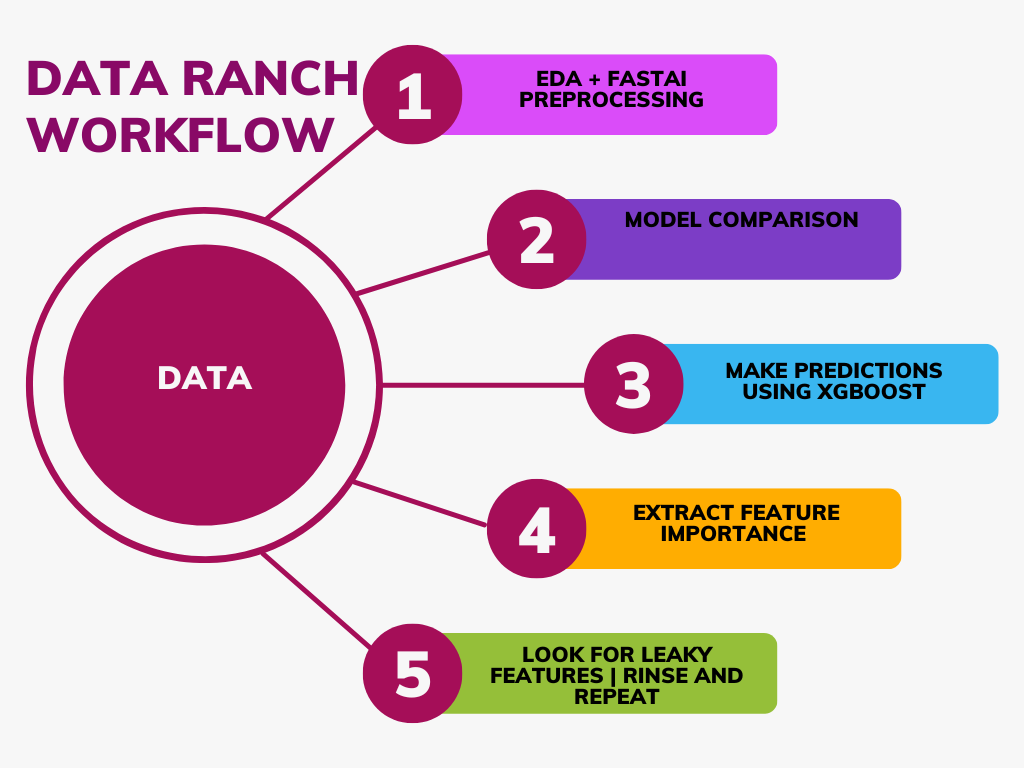

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil


In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'iran-protests-2022-tweets'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_PERCENT = False
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/iran-protests-2022-tweets
CSV!


In [12]:
df.head(1)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source
0,Saman Arbabi,NYC,"actress, singer, model, pimp and prostitute - our fatwa is bigger than yours",2010-11-23 18:48:21+00:00,113193.00,394,13460,True,2022-10-09 21:53:37+00:00,#Iranian protesters defacing Islamic Republic of #Iran’s embassy in #London #UK.\nCurrent Islamic flag replaced with pre-Islamic flag. IRI emblem at the door also vandalized. \n\n#مهسا_امینی #اعتراضات_سراسرى\n#MahsaAmini #Mahsa_Amini #IranProtests2022 #IranProtests #OpIran https://t.co/KBAASvd99I,"['Iranian', 'Iran', 'London', 'UK']",Twitter for iPhone


In [13]:
df.isna().sum()

user_name             0
user_location       941
user_description    337
user_created          0
user_followers        0
user_friends          0
user_favourites       0
user_verified         0
date                  0
text                  0
hashtags            639
source                0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

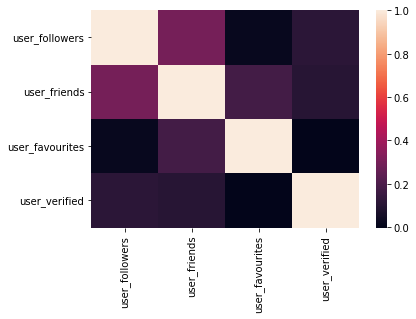

In [15]:
sns.heatmap(df.corr())

In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
user_followers,2000.00,11364.60,137158.20,0.00,34.00,343.50,2866.00,5556753.00
user_friends,2000.00,1312.31,5560.22,0.00,83.00,384.50,1231.00,194904.00
user_favourites,2000.00,22581.88,40221.70,0.00,931.75,6159.50,24928.00,608852.00


In [17]:
df.columns

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source'],
      dtype='object')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**More EDA 📊**</div>

In [18]:
def get_first_hashtag(hashtag_list):
    try:
        first_hashtag = hashtag_list.strip('][').split(', ')[0].replace('.','')
    except Exception:
        first_hashtag = ''
    return first_hashtag

In [19]:
df['first_hashtag'] = df['hashtags'].apply(get_first_hashtag)

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Top 10 Hashtags**</div>

In [20]:
hashtag = df['first_hashtag'].value_counts()[:10]
fig = px.bar(x=hashtag.index,y=hashtag.values,text=hashtag.values,
       color = hashtag.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribution of Top 10 Hashtags')
us,uk = [1,3,4,6],[0,2,5,8]

for idx in us:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "crimson"
for idx in uk:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "blue"
fig.show()

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Author Distribution**</div>

In [21]:
sentiment = df["user_name"].value_counts().sort_values(ascending=False).iloc[0:10]
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Tweeters Pie Graph",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

In [22]:
def get_all_str(tweet):
    sentence = ''
    for words in tweet:
        sentence += words
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

def get_hashtag(text):
    result = nltk.RegexpTokenizer(r'(?<=#)\w+').tokenize(text.lower())
    return result

def get_mention(text):
    result = nltk.RegexpTokenizer(r'(?<=@)\w+').tokenize(text.lower())
    return result 

def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

def remove_stopword(stopwords, lst):    
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist] 
#     print(stoplist)
    return cleanwordlist

def pos_remove_noun(tagged):
    remove_noun = [word for word,pos in tagged if pos not in ['NN','NNS','NNP','NNPS']]
    txt = ''
    for i in range(len(remove_noun)):
        txt += remove_noun[i]
        txt += '\n'
    return cleanwordlist

def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
#     txt= ' '.join(tokens)
    return tokens

def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=50,
               colormap= colormap,
               max_font_size=140,
               random_state=8888, 
               background_color=color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

In [23]:
# For NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [24]:
def whole_string(sent):
    all_str = get_all_str(sent)
    words = get_word(all_str)
    removed = remove_stopword(['http','https','co'],words)
    freq_df = Freq_df(removed)
    return freq_df

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Top 20 Terms**</div>

In [25]:
freq_df = whole_string(df['text'])
top_10 = freq_df[:20]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn, title = 'Rank of terms')

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

Target Variable: user_verified
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'date', 'text', 'hashtags', 'first_hashtag']
13
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_followers', 'user_friends', 'user_favourites']
Categorical variables that made the cut : ['user_verified', 'source']
Tabul

  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.03321413142556717, 'Adjusted R-Squared': 0.030785021203018403, 'RMSE': 0.25087399236308966, 'Time taken': 0.02347397804260254}
{'Model': 'BaggingRegressor', 'R-Squared': 0.047412579103613406, 'Adjusted R-Squared': 0.04501914337271795, 'RMSE': 0.24902498087612568, 'Time taken': 0.0288693904876709}
{'Model': 'BayesianRidge', 'R-Squared': 0.006586592276465297, 'Adjusted R-Squared': 0.004090578689220248, 'RMSE': 0.25430535354727024, 'Time taken': 0.029295682907104492}


 12%|█▏        | 5/42 [00:00<00:00, 47.95it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.04574687949541412, 'Adjusted R-Squared': 0.043349258589623796, 'RMSE': 0.24924260900746595, 'Time taken': 0.012259244918823242}
{'Model': 'DummyRegressor', 'R-Squared': -0.001536098310291889, 'Adjusted R-Squared': -0.0040525206678554415, 'RMSE': 0.25534290669607407, 'Time taken': 0.009703874588012695}
{'Model': 'ElasticNet', 'R-Squared': -0.001536098310291889, 'Adjusted R-Squared': -0.0040525206678554415, 'RMSE': 0.25534290669607407, 'Time taken': 0.012726783752441406}
{'Model': 'ElasticNetCV', 'R-Squared': 0.006586921925414102, 'Adjusted R-Squared': 0.004090909166432732, 'RMSE': 0.25430531135360807, 'Time taken': 0.06378364562988281}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.04468014455771152, 'Adjusted R-Squared': 0.0422798434133842, 'RMSE': 0.24938188103647982, 'Time taken': 0.009836673736572266}


 24%|██▍       | 10/42 [00:00<00:01, 29.28it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.03829400251128767, 'Adjusted R-Squared': 0.0358776557839291, 'RMSE': 0.2502140292559855, 'Time taken': 0.11629676818847656}
{'Model': 'GammaRegressor', 'R-Squared': 0.004741019555504877, 'Adjusted R-Squared': 0.0022403688508705333, 'RMSE': 0.25454146936587096, 'Time taken': 0.013280153274536133}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.2079248214218523, 'Adjusted R-Squared': -0.21095980841034945, 'RMSE': 0.2804209440725899, 'Time taken': 0.41730403900146484}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.04560978818017336, 'Adjusted R-Squared': 0.04321182282384217, 'RMSE': 0.2492605118936225, 'Time taken': 0.1062006950378418}


 40%|████      | 17/42 [00:01<00:01, 13.12it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.03174544112381683, 'Adjusted R-Squared': 0.029312640724630468, 'RMSE': 0.2510644773416572, 'Time taken': 0.10449433326721191}
{'Model': 'HuberRegressor', 'R-Squared': -0.07526881563140053, 'Adjusted R-Squared': -0.07797049607268547, 'RMSE': 0.2645751309129491, 'Time taken': 0.03291583061218262}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.17357910906298013, 'Adjusted R-Squared': -0.1765278002917816, 'RMSE': 0.2764054992217051, 'Time taken': 0.013763427734375}
{'Model': 'KernelRidge', 'R-Squared': -17.62259960305213, 'Adjusted R-Squared': -17.66939005431608, 'RMSE': 1.101059141989518, 'Time taken': 0.11874890327453613}
{'Model': 'Lars', 'R-Squared': 0.006568558129955604, 'Adjusted R-Squared': 0.004072499230784676, 'RMSE': 0.2543076618305864, 'Time taken': 0.019327878952026367}


 48%|████▊     | 20/42 [00:01<00:01, 14.83it/s]

{'Model': 'LarsCV', 'R-Squared': 0.006568558129955604, 'Adjusted R-Squared': 0.004072499230784676, 'RMSE': 0.2543076618305864, 'Time taken': 0.0313112735748291}
{'Model': 'Lasso', 'R-Squared': -0.001536098310291889, 'Adjusted R-Squared': -0.0040525206678554415, 'RMSE': 0.25534290669607407, 'Time taken': 0.019272804260253906}
{'Model': 'LassoCV', 'R-Squared': 0.006587181539388309, 'Adjusted R-Squared': 0.004091169432703379, 'RMSE': 0.25430527812411957, 'Time taken': 0.08740448951721191}
{'Model': 'LassoLars', 'R-Squared': -0.001536098310291889, 'Adjusted R-Squared': -0.0040525206678554415, 'RMSE': 0.25534290669607407, 'Time taken': 0.00992584228515625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.006568558129955604, 'Adjusted R-Squared': 0.004072499230784676, 'RMSE': 0.2543076618305864, 'Time taken': 0.014209747314453125}
{'Model': 'LassoLarsIC', 'R-Squared': 0.006568558129955604, 'Adjusted R-Squared': 0.004072499230784676, 'RMSE': 0.2543076618305864, 'Time taken': 0.01010274887084961}
{'Mod

 67%|██████▋   | 28/42 [00:01<00:01, 13.37it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.010455750705310685, 'Adjusted R-Squared': 0.007969458621655767, 'RMSE': 0.2538096346261983, 'Time taken': 0.452160120010376}
{'Model': 'NuSVR', 'R-Squared': -0.06426901126511742, 'Adjusted R-Squared': -0.06694305400698952, 'RMSE': 0.263218374421998, 'Time taken': 0.13078713417053223}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.006568558129955604, 'Adjusted R-Squared': 0.004072499230784676, 'RMSE': 0.2543076618305864, 'Time taken': 0.009742498397827148}
OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(1600, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.1365096800808123, 'Adjusted R-Squared': -1.1418777948548846, 'RMSE': 0.37294340076379, 'Time taken': 0.011023521423339844}
{'Model': 'PoissonRegressor', 'R-Squared': 0.004894684327754639, 'Adjusted R-Squared': 0.0023944197155129077, 'RMSE': 0.2545218184169349, 'Time take

 76%|███████▌  | 32/42 [00:27<00:22,  2.26s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.07526881741822211, 'Adjusted R-Squared': -0.07797049786399657, 'RMSE': 0.2645751311327772, 'Time taken': 25.92365860939026}
{'Model': 'RANSACRegressor', 'R-Squared': -0.07526881720430101, 'Adjusted R-Squared': -0.0779704976495379, 'RMSE': 0.2645751311064591, 'Time taken': 0.047393083572387695}


 81%|████████  | 34/42 [00:28<00:14,  1.84s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.04489691152090247, 'Adjusted R-Squared': 0.042497155017186206, 'RMSE': 0.24935358641894295, 'Time taken': 0.18033695220947266}
{'Model': 'Ridge', 'R-Squared': 0.006569063865955016, 'Adjusted R-Squared': 0.004073006237477528, 'RMSE': 0.25430759709911605, 'Time taken': 0.011418819427490234}
{'Model': 'RidgeCV', 'R-Squared': 0.0065732777052472935, 'Adjusted R-Squared': 0.004077230664305764, 'RMSE': 0.2543070577498556, 'Time taken': 0.009768486022949219}
{'Model': 'SGDRegressor', 'R-Squared': 0.005680292271065368, 'Adjusted R-Squared': 0.0031820015481284214, 'RMSE': 0.25442132963482766, 'Time taken': 0.010171175003051758}
{'Model': 'SVR', 'R-Squared': -0.011818802263045658, 'Adjusted R-Squared': -0.014361060560188932, 'RMSE': 0.25665035364737815, 'Time taken': 0.038667917251586914}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.006568558129955604, 'Adjusted R-Squared': 0.004072499230784676, 'RMSE': 0.2543076618305864, 'Time taken': 

100%|██████████| 42/42 [00:28<00:00,  1.46it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.025242803904871103, 'Adjusted R-Squared': 0.022793665221215065, 'RMSE': 0.25190613, 'Time taken': 0.39009737968444824}
{'Model': 'LGBMRegressor', 'R-Squared': 0.03174544112381683, 'Adjusted R-Squared': 0.029312640724630468, 'RMSE': 0.2510644773416572, 'Time taken': 0.068359375}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_verified
user_verified
Target Standard Deviation: 0.27129319932501067
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
BaggingRegressor                             0.05       0.05  0.25        0.03
DecisionTreeRegressor                        0.04       0.05  0.25        0.01
GradientBoostingRegressor                    0.04       0.05  0.25        0.11
RandomForestRegressor                        0.04       0.04  0.25        0.18
ExtraTreeRegressor                           0.04       0.04  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,10.281662,0.768228,0.876486,00:01
1,4.999587,0.110568,0.332517,00:01
2,2.853017,0.151163,0.388797,00:01


Better model found at epoch 0 with _rmse value: 0.8764862418174744.
Better model found at epoch 1 with _rmse value: 0.33251726627349854.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.15
1       1       1.07
2       1       1.15
3       1       1.02
4       1       1.15
XGBoost RMSE:  0.2520438


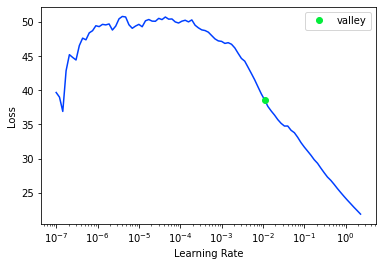

<Figure size 720x720 with 0 Axes>

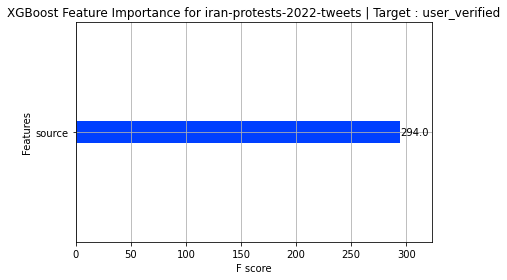

Target Variable: user_favourites
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'date', 'text', 'hashtags', 'first_hashtag']
12
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_followers', 'user_friends']
Categorical variables that made the cut : ['user_verified', 'source']
Tabular Object size: 2000


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.11706980027478808, 'Adjusted R-Squared': -0.12269735594367859, 'RMSE': 39997.149455546, 'Time taken': 0.02321481704711914}
{'Model': 'BaggingRegressor', 'R-Squared': 0.003020705430556103, 'Adjusted R-Squared': -0.0020018602851588074, 'RMSE': 37786.09001513404, 'Time taken': 0.028928041458129883}
{'Model': 'BayesianRidge', 'R-Squared': -0.0013998274145314848, 'Adjusted R-Squared': -0.006444662817123525, 'RMSE': 37869.767734127825, 'Time taken': 0.010169267654418945}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.004194362598285983, 'Adjusted R-Squared': -0.0008222904868611103, 'RMSE': 37763.84232400644, 'Time taken': 0.009716510772705078}
{'Model': 'DummyRegressor', 'R-Squared': -0.001399823433283487, 'Adjusted R-Squared': -0.006444658815818904, 'RMSE': 37869.77, 'Time taken': 0.009065628051757812}
{'Model': 'ElasticNet', 'R-Squared': 0.0003694713426004581, 'Adjusted R-Squared': -0.004666450716126924, 'RMSE': 37836.29830815701, 'Time tak

 17%|█▋        | 7/42 [00:00<00:00, 43.38it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -8.20267849066525e-06, 'Adjusted R-Squared': -0.005046027377122897, 'RMSE': 37843.44516744729, 'Time taken': 0.06923151016235352}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.00775178731164905, 'Adjusted R-Squared': 0.002753055761581802, 'RMSE': 37696.32803364169, 'Time taken': 0.011910676956176758}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.008313993691966615, 'Adjusted R-Squared': 0.0033180944158557324, 'RMSE': 37685.64717843232, 'Time taken': 0.12187457084655762}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 29%|██▊       | 12/42 [00:00<00:02, 13.32it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.0061908160327261985, 'Adjusted R-Squared': 0.0011842206475006778, 'RMSE': 37725.96767441212, 'Time taken': 0.38660120964050293}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.004357774578982565, 'Adjusted R-Squared': -0.0006580552720047983, 'RMSE': 37760.74366839022, 'Time taken': 0.10045719146728516}


 36%|███▌      | 15/42 [00:00<00:01, 14.66it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.0018028226052849705, 'Adjusted R-Squared': -0.003225878540280336, 'RMSE': 37809.16220178439, 'Time taken': 0.12543320655822754}
{'Model': 'HuberRegressor', 'R-Squared': -0.15373494109441155, 'Adjusted R-Squared': -0.15954720780017673, 'RMSE': 40648.255163826536, 'Time taken': 0.01762080192565918}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.012950037676957571, 'Adjusted R-Squared': -0.01805306053679101, 'RMSE': 38087.535, 'Time taken': 0.012415409088134766}
{'Model': 'KernelRidge', 'R-Squared': -0.3905525874281972, 'Adjusted R-Squared': -0.397557890135644, 'RMSE': 44625.448519019534, 'Time taken': 0.13660955429077148}
{'Model': 'Lars', 'R-Squared': 0.0008787886553958124, 'Adjusted R-Squared': -0.004154567573040335, 'RMSE': 37826.65817788722, 'Time taken': 0.020756244659423828}


 48%|████▊     | 20/42 [00:01<00:01, 15.38it/s]

{'Model': 'LarsCV', 'R-Squared': -0.0013998298455466518, 'Adjusted R-Squared': -0.0064446652603855625, 'RMSE': 37869.76778009447, 'Time taken': 0.03236675262451172}
{'Model': 'Lasso', 'R-Squared': 0.0008790956593481836, 'Adjusted R-Squared': -0.004154259022468576, 'RMSE': 37826.65236631285, 'Time taken': 0.029024362564086914}
{'Model': 'LassoCV', 'R-Squared': 0.0008791093976401321, 'Adjusted R-Squared': -0.004154245214966101, 'RMSE': 37826.65210624743, 'Time taken': 0.08562898635864258}
{'Model': 'LassoLars', 'R-Squared': 0.0008883511172730341, 'Adjusted R-Squared': -0.004144956937551791, 'RMSE': 37826.477160389964, 'Time taken': 0.011769771575927734}
{'Model': 'LassoLarsCV', 'R-Squared': -0.0013998298455466518, 'Adjusted R-Squared': -0.0064446652603855625, 'RMSE': 37869.76778009447, 'Time taken': 0.01571369171142578}
{'Model': 'LassoLarsIC', 'R-Squared': -0.0013998298455466518, 'Adjusted R-Squared': -0.0064446652603855625, 'RMSE': 37869.76778009447, 'Time taken': 0.01045083999633789}


 62%|██████▏   | 26/42 [00:03<00:03,  4.34it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.37634065576728637, 'Adjusted R-Squared': -0.38327436184168073, 'RMSE': 44396.819038861475, 'Time taken': 2.3641722202301025}
{'Model': 'NuSVR', 'R-Squared': -0.08708294253598159, 'Adjusted R-Squared': -0.09255943091147767, 'RMSE': 39456.65150445955, 'Time taken': 0.19576644897460938}


 67%|██████▋   | 28/42 [00:03<00:02,  4.84it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0013579738889292203, 'Adjusted R-Squared': -0.003672968308103819, 'RMSE': 37817.58613053041, 'Time taken': 0.011600732803344727}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0013579738889292203, 'Adjusted R-Squared': -0.003672968308103819, 'RMSE': 37817.58613053041, 'Time taken': 0.016097307205200195}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.23065678323624939, 'Adjusted R-Squared': -0.23685656551955536, 'RMSE': 41981.44281306382, 'Time taken': 0.01966071128845215}
{'Model': 'PoissonRegressor', 'R-Squared': 0.0008124054292862892, 'Adjusted R-Squared': -0.004221285223462878, 'RMSE': 37827.91478913019, 'Time taken': 0.011328458786010742}


 76%|███████▌  | 32/42 [01:08<00:58,  5.82s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2192462481446784, 'Adjusted R-Squared': -0.22538854662399666, 'RMSE': 41786.365561335166, 'Time taken': 64.86205911636353}
{'Model': 'RANSACRegressor', 'R-Squared': -0.304562648921189, 'Adjusted R-Squared': -0.3111347529459807, 'RMSE': 43223.64178973756, 'Time taken': 0.05672144889831543}


 81%|████████  | 34/42 [01:09<00:37,  4.68s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.005519504391836683, 'Adjusted R-Squared': 0.0005095270839871047, 'RMSE': 37738.707346297335, 'Time taken': 0.2214803695678711}
{'Model': 'Ridge', 'R-Squared': 0.0008780903258737149, 'Adjusted R-Squared': -0.004155269420595298, 'RMSE': 37826.67139723799, 'Time taken': 0.010880470275878906}
{'Model': 'RidgeCV', 'R-Squared': 0.0008718000191763053, 'Adjusted R-Squared': -0.004161591416495192, 'RMSE': 37826.79047229161, 'Time taken': 0.009808540344238281}
{'Model': 'SGDRegressor', 'R-Squared': -0.000914251750552264, 'Adjusted R-Squared': -0.005956640928136858, 'RMSE': 37860.58515450394, 'Time taken': 0.01065373420715332}


 90%|█████████ | 38/42 [01:09<00:11,  3.00s/it]

{'Model': 'SVR', 'R-Squared': -0.21915129722195248, 'Adjusted R-Squared': -0.22529311735909063, 'RMSE': 41784.738436698346, 'Time taken': 0.18769097328186035}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0008787886553958124, 'Adjusted R-Squared': -0.004154567573040335, 'RMSE': 37826.65817788722, 'Time taken': 0.012201786041259766}
{'Model': 'TweedieRegressor', 'R-Squared': 1.7701409015802305e-05, 'Adjusted R-Squared': -0.005019992790434857, 'RMSE': 37842.955018336, 'Time taken': 0.011417865753173828}


100%|██████████| 42/42 [01:09<00:00,  1.66s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.007687089737542618, 'Adjusted R-Squared': 0.0026880322551121605, 'RMSE': 37697.555, 'Time taken': 0.4174017906188965}
{'Model': 'LGBMRegressor', 'R-Squared': 0.0018028226052849705, 'Adjusted R-Squared': -0.003225878540280336, 'RMSE': 37809.16220178439, 'Time taken': 0.04369926452636719}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_favourites
user_favourites
Target Standard Deviation: 40777.3359375
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
ExtraTreesRegressor                          0.00       0.01 37685.65   
ExtraTreeRegressor                           0.00       0.01 37696.33   
XGBRegressor                                 0.00       0.01 37697.55   
GaussianProcessRegressor                     0.00       0.01 37725.97   
RandomForestRegressor                        0.00       0.01 37738.71   
GradientBoostingRe

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,2130393856.000000,1994062080.000000,44654.921875,00:01
1,2159593728.000000,1987521280.000000,44581.625000,00:01
2,2170579456.000000,1887059328.000000,43440.296875,00:01
3,2053245312.000000,1571266688.000000,39639.210938,00:01
4,1889223424.000000,1637282304.000000,40463.347656,00:01


Better model found at epoch 0 with _rmse value: 44654.921875.
Better model found at epoch 1 with _rmse value: 44581.625.
Better model found at epoch 2 with _rmse value: 43440.296875.
Better model found at epoch 3 with _rmse value: 39639.2109375.
No improvement since epoch 3: early stopping


,user_verified,source,user_favourites,user_favourites_pred
0,1.00,12.00,5493.00,11950.93
1,1.00,12.00,28792.00,11950.93
2,1.00,14.00,6653.00,12815.32
3,1.00,12.00,1151.00,11950.93
4,1.00,14.00,32.00,12815.32
5,1.00,14.00,102574.00,12815.32
6,1.00,11.00,44647.00,10608.38
7,1.00,12.00,6993.00,11950.93
8,1.00,14.00,42647.00,12815.32


<Figure size 432x288 with 0 Axes>

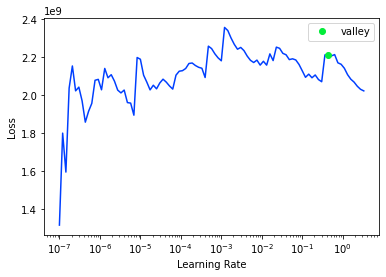

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0 46295.00   23478.54
1    69.00   18840.22
2  6476.00    3650.00
3  1969.00   18840.22
4 32638.00   23160.21
XGBoost RMSE:  37697.555


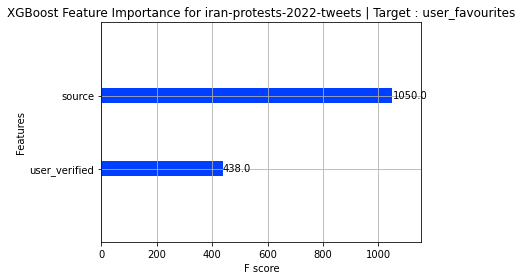

Target Variable: user_friends
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_favourites', 'date', 'text', 'hashtags', 'first_hashtag']
12
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_followers', 'user_favourites']
Categorical variables that made the cut : ['user_verified', 'source']
Tabular Object size: 2000


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.0030823751787814047, 'Adjusted R-Squared': -0.001939879858101179, 'RMSE': 10495.488007667724, 'Time taken': 0.0204775333404541}
{'Model': 'BaggingRegressor', 'R-Squared': 0.00696770775446276, 'Adjusted R-Squared': 0.001965026181437457, 'RMSE': 10475.015769043815, 'Time taken': 0.028130054473876953}
{'Model': 'BayesianRidge', 'R-Squared': 0.0012551078061966425, 'Adjusted R-Squared': -0.0037763526078777865, 'RMSE': 10505.102283919445, 'Time taken': 0.011037111282348633}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.005834508500449642, 'Adjusted R-Squared': 0.0008261181150615027, 'RMSE': 10480.99084942886, 'Time taken': 0.009843826293945312}
{'Model': 'DummyRegressor', 'R-Squared': -0.003915202411850727, 'Adjusted R-Squared': -0.008972709728786832, 'RMSE': 10532.258, 'Time taken': 0.008915424346923828}
{'Model': 'ElasticNet', 'R-Squared': 0.0002172538621217912, 'Adjusted R-Squared': -0.004819435035298136, 'RMSE': 10510.55909825241, 'Time t

 17%|█▋        | 7/42 [00:00<00:00, 44.30it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.00023841324988982393, 'Adjusted R-Squared': -0.005277397699511299, 'RMSE': 10512.95400382101, 'Time taken': 0.06929802894592285}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.005815911623306191, 'Adjusted R-Squared': 0.0008074275508795914, 'RMSE': 10481.088877769878, 'Time taken': 0.011430740356445312}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.005805469687086173, 'Adjusted R-Squared': 0.0007969330104469208, 'RMSE': 10481.14391917292, 'Time taken': 0.1151268482208252}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 29%|██▊       | 12/42 [00:00<00:02, 13.16it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.005826114400459992, 'Adjusted R-Squared': 0.0008176817274144765, 'RMSE': 10481.035096739908, 'Time taken': 0.39133214950561523}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.005856539566268082, 'Adjusted R-Squared': 0.0008482601686170543, 'RMSE': 10480.874717516977, 'Time taken': 0.11485671997070312}


 36%|███▌      | 15/42 [00:00<00:01, 14.61it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.006776118083282601, 'Adjusted R-Squared': 0.0017724713229969602, 'RMSE': 10476.026213543844, 'Time taken': 0.12052607536315918}
{'Model': 'HuberRegressor', 'R-Squared': -0.015177702704316287, 'Adjusted R-Squared': -0.020291948057990394, 'RMSE': 10591.172338120445, 'Time taken': 0.016816377639770508}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.004638797697462227, 'Adjusted R-Squared': -0.009699950330698703, 'RMSE': 10536.054, 'Time taken': 0.012458086013793945}
{'Model': 'KernelRidge', 'R-Squared': -0.025111878528658815, 'Adjusted R-Squared': -0.030276170108148204, 'RMSE': 10642.866943595858, 'Time taken': 0.15749287605285645}


 48%|████▊     | 20/42 [00:01<00:01, 15.07it/s]

{'Model': 'Lars', 'R-Squared': 0.0018384423291643026, 'Adjusted R-Squared': -0.0031900793719481513, 'RMSE': 10502.033990940556, 'Time taken': 0.02547621726989746}
{'Model': 'LarsCV', 'R-Squared': 0.0018384423291643026, 'Adjusted R-Squared': -0.0031900793719481513, 'RMSE': 10502.033990940556, 'Time taken': 0.03338885307312012}
{'Model': 'Lasso', 'R-Squared': 0.0018243298154176912, 'Adjusted R-Squared': -0.003204262981481909, 'RMSE': 10502.10823221646, 'Time taken': 0.020224332809448242}
{'Model': 'LassoCV', 'R-Squared': 0.0018346344688485727, 'Adjusted R-Squared': -0.0031939064154393737, 'RMSE': 10502.0540228883, 'Time taken': 0.08314275741577148}
{'Model': 'LassoLars', 'R-Squared': 0.0012425884051738834, 'Adjusted R-Squared': -0.003788935078931077, 'RMSE': 10505.168125145346, 'Time taken': 0.011340618133544922}
{'Model': 'LassoLarsCV', 'R-Squared': 0.0018384423291643026, 'Adjusted R-Squared': -0.0031900793719481513, 'RMSE': 10502.033990940556, 'Time taken': 0.016485929489135742}
{'Mode

 62%|██████▏   | 26/42 [00:03<00:03,  4.58it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.016746963164178785, 'Adjusted R-Squared': -0.02186911411210901, 'RMSE': 10599.355087788828, 'Time taken': 2.200212240219116}
{'Model': 'NuSVR', 'R-Squared': -0.012336886959261273, 'Adjusted R-Squared': -0.017436820898602656, 'RMSE': 10576.343088326981, 'Time taken': 0.19228386878967285}


 67%|██████▋   | 28/42 [00:03<00:02,  5.09it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.00404798461017164, 'Adjusted R-Squared': -0.0009694058955704854, 'RMSE': 10490.403837616552, 'Time taken': 0.012718677520751953}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0018384423291643026, 'Adjusted R-Squared': -0.0031900793719481513, 'RMSE': 10502.033990940556, 'Time taken': 0.016592025756835938}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.01696125395896697, 'Adjusted R-Squared': -0.022084484457500775, 'RMSE': 10600.471995260941, 'Time taken': 0.01112985610961914}
{'Model': 'PoissonRegressor', 'R-Squared': 8.700696887709025e-05, 'Adjusted R-Squared': -0.004950338084176442, 'RMSE': 10511.243708529679, 'Time taken': 0.011999130249023438}


 79%|███████▊  | 33/42 [01:04<00:43,  4.82s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.019239651443279326, 'Adjusted R-Squared': -0.024374360014781882, 'RMSE': 10612.33998737713, 'Time taken': 60.22003126144409}
{'Model': 'RANSACRegressor', 'R-Squared': -0.02496711724214906, 'Adjusted R-Squared': -0.030130679545635974, 'RMSE': 10642.11545025222, 'Time taken': 0.0912630558013916}


 83%|████████▎ | 35/42 [01:04<00:25,  3.68s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.005576216033103987, 'Adjusted R-Squared': 0.0005665244262179625, 'RMSE': 10482.352285325082, 'Time taken': 0.15941143035888672}
{'Model': 'Ridge', 'R-Squared': 0.0018356672296531151, 'Adjusted R-Squared': -0.0031928684518094386, 'RMSE': 10502.048589864404, 'Time taken': 0.011246442794799805}
{'Model': 'RidgeCV', 'R-Squared': 0.0018108059926067455, 'Adjusted R-Squared': -0.003217854934382647, 'RMSE': 10502.179376091255, 'Time taken': 0.015083074569702148}
{'Model': 'SGDRegressor', 'R-Squared': 0.0014852362151414056, 'Adjusted R-Squared': -0.0035450648618602365, 'RMSE': 10503.891933924526, 'Time taken': 0.015635013580322266}


 90%|█████████ | 38/42 [01:04<00:09,  2.45s/it]

{'Model': 'SVR', 'R-Squared': -0.01878079180079828, 'Adjusted R-Squared': -0.023913188736822466, 'RMSE': 10609.950891389171, 'Time taken': 0.20815038681030273}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.0018384423291643026, 'Adjusted R-Squared': -0.0031900793719481513, 'RMSE': 10502.033990940556, 'Time taken': 0.011955499649047852}
{'Model': 'TweedieRegressor', 'R-Squared': -0.0006915046033220129, 'Adjusted R-Squared': -0.005732771629031408, 'RMSE': 10515.334830826889, 'Time taken': 0.010473251342773438}


100%|██████████| 42/42 [01:05<00:00,  1.55s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.005814268760009678, 'Adjusted R-Squared': 0.000805776411193615, 'RMSE': 10481.097, 'Time taken': 0.40726470947265625}
{'Model': 'LGBMRegressor', 'R-Squared': 0.006776118083282601, 'Adjusted R-Squared': 0.0017724713229969602, 'RMSE': 10476.026213543844, 'Time taken': 0.0464327335357666}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_friends
user_friends
Target Standard Deviation: 3303.82275390625
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
BaggingRegressor                             0.00       0.01 10475.02   
LGBMRegressor                                0.00       0.01 10476.03   
HistGradientBoostingRegressor                0.00       0.01 10476.03   
GradientBoostingRegressor                    0.00       0.01 10480.87   
DecisionTreeRegressor                        0.00       0.01 10480.99   
GaussianProcessRegress

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,11557258.000000,113856120.000000,10670.337891,00:01
1,11879652.000000,113510512.000000,10654.132812,00:01
2,11527000.000000,110654952.000000,10519.267578,00:01
3,11324026.000000,110662112.000000,10519.607422,00:01


Better model found at epoch 0 with _rmse value: 10670.337890625.
Better model found at epoch 1 with _rmse value: 10654.1328125.
Better model found at epoch 2 with _rmse value: 10519.267578125.
No improvement since epoch 2: early stopping


,user_verified,source,user_friends,user_friends_pred
0,1.00,12.00,429.00,1264.37
1,1.00,11.00,59.00,1415.00
2,1.00,11.00,2234.00,1415.00
3,1.00,12.00,58.00,1264.37
4,1.00,14.00,120.00,1324.45
5,1.00,13.00,26.00,1516.63
6,1.00,12.00,204.00,1264.37
7,1.00,14.00,2024.00,1324.45
8,1.00,12.00,6.00,1264.37


<Figure size 432x288 with 0 Axes>

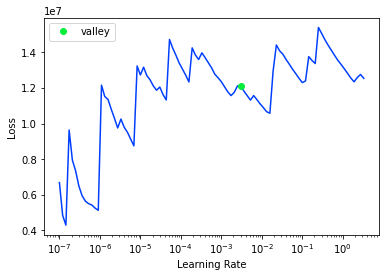

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0 2428.00     958.80
1  589.00    1091.35
2  730.00     958.80
3 4229.00     837.30
4  121.00    1834.04
XGBoost RMSE:  10481.097


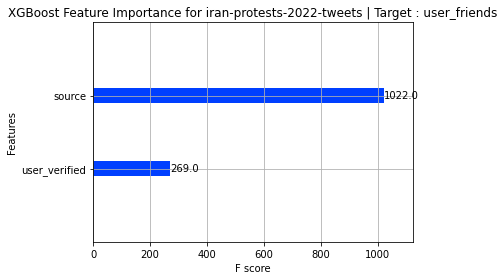

Target Variable: user_followers
CATS=====================
['user_verified', 'source']
CONTS=====================
['user_name', 'user_location', 'user_description', 'user_created', 'user_friends', 'user_favourites', 'date', 'text', 'hashtags', 'first_hashtag']
12
Could not convert user_name to float.
Could not convert user_location to float.
Could not convert user_description to float.
Could not convert user_created to float.
Could not convert date to float.
Could not convert text to float.
Could not convert hashtags to float.
Could not convert first_hashtag to float.
Looping through continuous variables to find breakpoint
Error with  user_name
Error with  user_location
Error with  user_description
Error with  user_created
Error with  date
Error with  text
Error with  hashtags
Error with  first_hashtag
Continuous variables that made the cut : ['user_friends', 'user_favourites']
Categorical variables that made the cut : ['user_verified', 'source']
Tabular Object size: 2000


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.03340234615599458, 'Adjusted R-Squared': 0.028532836564840958, 'RMSE': 114829.95303054774, 'Time taken': 0.018290996551513672}
{'Model': 'BaggingRegressor', 'R-Squared': 0.049064604755600816, 'Adjusted R-Squared': 0.044273998230440204, 'RMSE': 113895.83037720057, 'Time taken': 0.028872966766357422}
{'Model': 'BayesianRidge', 'R-Squared': -0.0011998959120718133, 'Adjusted R-Squared': -0.0062437241030646184, 'RMSE': 116867.22092452909, 'Time taken': 0.010229349136352539}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.0472753889781099, 'Adjusted R-Squared': 0.04247576877145054, 'RMSE': 114002.92937211654, 'Time taken': 0.010440826416015625}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011998320554462705, 'Adjusted R-Squared': -0.006243659924743072, 'RMSE': 116867.22, 'Time taken': 0.008943319320678711}
{'Model': 'ElasticNet', 'R-Squared': 0.030593007640617564, 'Adjusted R-Squared': 0.025709345210595536, 'RMSE': 114996.70397831872, 'Time tak

 17%|█▋        | 7/42 [00:00<00:00, 44.94it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.003850899209138947, 'Adjusted R-Squared': -0.0011674841701601046, 'RMSE': 116572.06572207504, 'Time taken': 0.0688619613647461}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.01602517722589969, 'Adjusted R-Squared': 0.011068125221999958, 'RMSE': 115857.54240955094, 'Time taken': 0.011379480361938477}
{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.04280769102422732, 'Adjusted R-Squared': 0.037985563523090016, 'RMSE': 114269.91887346497, 'Time taken': 0.11679792404174805}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 29%|██▊       | 12/42 [00:00<00:02, 13.45it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.04695102435477427, 'Adjusted R-Squared': 0.04214977006940801, 'RMSE': 114022.33443939745, 'Time taken': 0.3662080764770508}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.04644017827985325, 'Adjusted R-Squared': 0.04163635046262337, 'RMSE': 114052.88903847212, 'Time taken': 0.1230764389038086}


 36%|███▌      | 15/42 [00:00<00:01, 14.76it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.05242674910836076, 'Adjusted R-Squared': 0.047653080338125875, 'RMSE': 113694.30601403186, 'Time taken': 0.11857724189758301}
{'Model': 'HuberRegressor', 'R-Squared': 0.01704993241543229, 'Adjusted R-Squared': 0.01209804290619021, 'RMSE': 115797.19709241224, 'Time taken': 0.02274465560913086}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.03935325023892955, 'Adjusted R-Squared': 0.034513720013433, 'RMSE': 114475.93, 'Time taken': 0.0131988525390625}


 48%|████▊     | 20/42 [00:01<00:01, 14.99it/s]

{'Model': 'KernelRidge', 'R-Squared': 0.028726587298051998, 'Adjusted R-Squared': 0.023833522246656802, 'RMSE': 115107.35357113813, 'Time taken': 0.1708662509918213}
{'Model': 'Lars', 'R-Squared': 0.04220751958363256, 'Adjusted R-Squared': 0.03738236854878951, 'RMSE': 114305.73758731366, 'Time taken': 0.02011704444885254}
{'Model': 'LarsCV', 'R-Squared': 0.04220751958363256, 'Adjusted R-Squared': 0.03738236854878951, 'RMSE': 114305.73758731366, 'Time taken': 0.03364300727844238}
{'Model': 'Lasso', 'R-Squared': 0.04220485039751576, 'Adjusted R-Squared': 0.03737968591589125, 'RMSE': 114305.89686141608, 'Time taken': 0.021119117736816406}
{'Model': 'LassoCV', 'R-Squared': 0.042180495834711396, 'Adjusted R-Squared': 0.037355208660075245, 'RMSE': 114307.35012229788, 'Time taken': 0.08275127410888672}
{'Model': 'LassoLars', 'R-Squared': 0.04210047243245274, 'Adjusted R-Squared': 0.037274782117251104, 'RMSE': 114312.12506787502, 'Time taken': 0.011444091796875}
{'Model': 'LassoLarsCV', 'R-Squ

 62%|██████▏   | 26/42 [00:03<00:03,  4.57it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.01406005582201919, 'Adjusted R-Squared': -0.019168670712810254, 'RMSE': 117615.3910510125, 'Time taken': 2.2039594650268555}
{'Model': 'NuSVR', 'R-Squared': -0.01253363248147532, 'Adjusted R-Squared': -0.0176345575821375, 'RMSE': 117526.83688299089, 'Time taken': 0.19213318824768066}


 67%|██████▋   | 28/42 [00:03<00:02,  5.07it/s]

{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.04808398464897912, 'Adjusted R-Squared': 0.043288437972147875, 'RMSE': 113954.54086529552, 'Time taken': 0.01245260238647461}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.04220751958363256, 'Adjusted R-Squared': 0.03738236854878951, 'RMSE': 114305.73758731366, 'Time taken': 0.01661539077758789}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.016560217463028937, 'Adjusted R-Squared': 0.011605860875940954, 'RMSE': 115826.03912591134, 'Time taken': 0.012863397598266602}
{'Model': 'PoissonRegressor', 'R-Squared': 0.03306067783312128, 'Adjusted R-Squared': 0.028189446990970812, 'RMSE': 114850.24600916395, 'Time taken': 0.01281428337097168}


 76%|███████▌  | 32/42 [01:39<01:25,  8.55s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.014943052259450695, 'Adjusted R-Squared': -0.020056115495014515, 'RMSE': 117666.58692088327, 'Time taken': 96.04104566574097}
{'Model': 'RANSACRegressor', 'R-Squared': 0.008968792546679705, 'Adjusted R-Squared': 0.003976192005353263, 'RMSE': 116272.2252354017, 'Time taken': 0.0934138298034668}


 81%|████████  | 34/42 [01:40<00:54,  6.86s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.047030783564304124, 'Adjusted R-Squared': 0.04222993108855766, 'RMSE': 114017.56316227703, 'Time taken': 0.1674656867980957}
{'Model': 'Ridge', 'R-Squared': 0.0421880486772892, 'Adjusted R-Squared': 0.03736279955223787, 'RMSE': 114306.89943867785, 'Time taken': 0.012781381607055664}
{'Model': 'RidgeCV', 'R-Squared': 0.04201353453968604, 'Adjusted R-Squared': 0.03718740625021344, 'RMSE': 114317.31237066808, 'Time taken': 0.009943008422851562}
{'Model': 'SGDRegressor', 'R-Squared': 0.045876150023576145, 'Adjusted R-Squared': 0.041069480754173604, 'RMSE': 114086.61505169986, 'Time taken': 0.010942459106445312}


 90%|█████████ | 38/42 [01:40<00:17,  4.39s/it]

{'Model': 'SVR', 'R-Squared': -0.014663092970204739, 'Adjusted R-Squared': -0.019774745831515617, 'RMSE': 117650.35737680615, 'Time taken': 0.18834495544433594}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.04220751958363256, 'Adjusted R-Squared': 0.03738236854878951, 'RMSE': 114305.73758731366, 'Time taken': 0.011869430541992188}
{'Model': 'TweedieRegressor', 'R-Squared': 0.02379819433362096, 'Adjusted R-Squared': 0.01888030110608263, 'RMSE': 115399.02039180644, 'Time taken': 0.011690616607666016}


100%|██████████| 42/42 [01:40<00:00,  2.40s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.04717515716991416, 'Adjusted R-Squared': 0.042375032017117786, 'RMSE': 114008.93, 'Time taken': 0.41233348846435547}
{'Model': 'LGBMRegressor', 'R-Squared': 0.05237781777187456, 'Adjusted R-Squared': 0.047603902496166195, 'RMSE': 113697.24148235667, 'Time taken': 0.04537463188171387}
Project: iran-protests-2022-tweets
iran-protests-2022-tweets
Target: user_followers
user_followers
Target Standard Deviation: 141739.34375
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor                0.05       0.05 113694.31   
LGBMRegressor                                0.05       0.05 113697.24   
BaggingRegressor                             0.04       0.05 113895.83   
OrthogonalMatchingPursuit                    0.04       0.05 113954.54   
DecisionTreeRegressor                        0.04       0.05 114002.93   
XGBRegressor     

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,24286191616.000000,13854593024.000000,117705.523438,00:01
1,20242774016.000000,13852516352.000000,117696.703125,00:01
2,21811662848.000000,13791353856.000000,117436.609375,00:01
3,22271305728.000000,13666421760.000000,116903.476562,00:01
4,21223122944.000000,13740433408.000000,117219.617188,00:01


Better model found at epoch 0 with _rmse value: 117705.5234375.
Better model found at epoch 1 with _rmse value: 117696.703125.
Better model found at epoch 2 with _rmse value: 117436.609375.
Better model found at epoch 3 with _rmse value: 116903.4765625.
No improvement since epoch 3: early stopping


,user_verified,source,user_followers,user_followers_pred
0,1.00,12.00,32.00,13552.02
1,1.00,14.00,12.00,25998.46
2,1.00,12.00,164.00,13552.02
3,2.00,5.00,32259.00,21509.96
4,1.00,14.00,12.00,25998.46
5,1.00,14.00,1410.00,25998.46
6,1.00,11.00,0.00,25329.51
7,1.00,12.00,13.00,13552.02
8,1.00,12.00,19.00,13552.02


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
    actual  predicted
0    67.00    2983.74
1     0.00   19527.90
2  1442.00   62103.02
3     0.00   19527.90
4 20627.00   36829.37
XGBoost RMSE:  113791.43


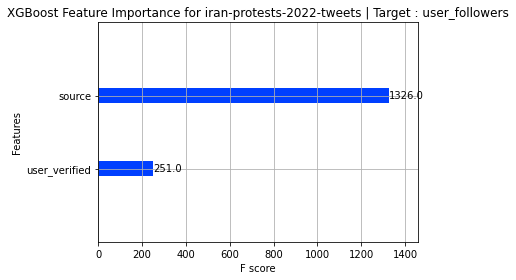

<Figure size 432x288 with 0 Axes>

In [26]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

         feature  importance
0         source      294.00
0  user_verified      251.00
1         source     1326.00
0  user_verified      269.00
1         source     1022.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

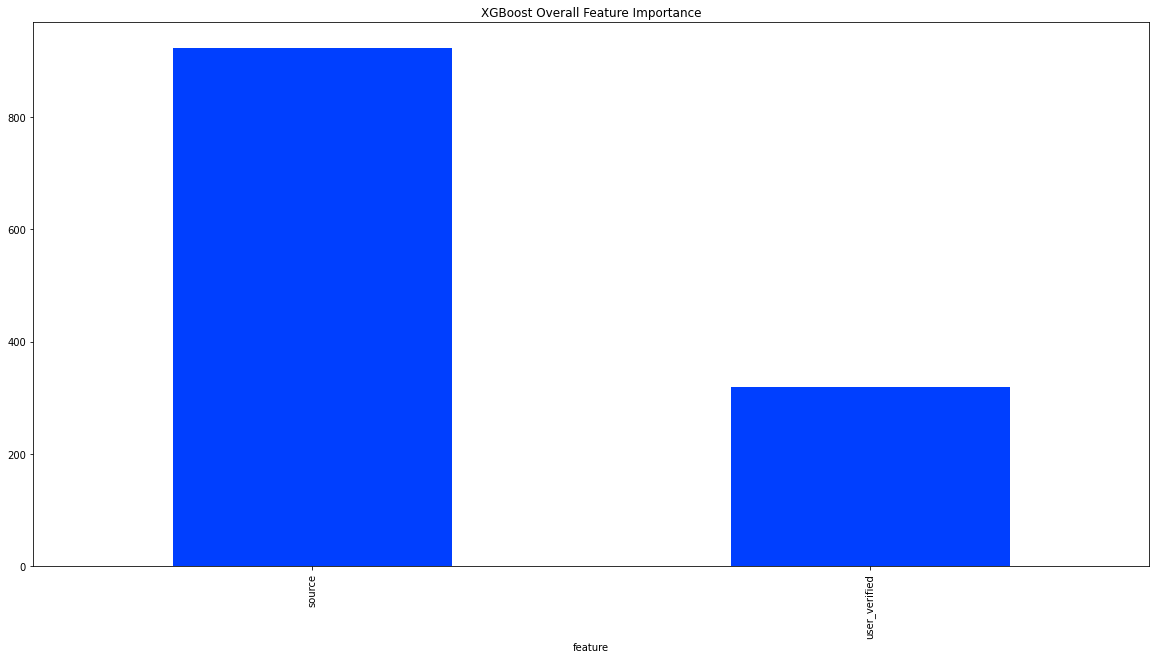

In [27]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [28]:
df.isna().sum()

user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
first_hashtag       0
dtype: int64

# **To Be Continued...**